# Can we use the Federal Prime Lending Rate to predict Mutual Fund Performance?

In [45]:
import yfinance as yf
import pandas as pd
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts

import warnings 


%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Yahoo Finance Data on the XLV Fund

In [46]:
xlv = yf.Ticker('XLV')
xlv_hist = xlv.history(period = 'max', actions = False)
xlv_hist['Change'] = xlv_hist['Close'] - xlv_hist['Open']
xlv_hist['Volume'] = xlv_hist.Volume.astype('float64')
xlv_hist.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-12-22,18.41,18.60,18.41,18.58,5700.0,0.17
1998-12-23,18.69,18.99,18.69,18.99,18100.0,0.30
1998-12-24,19.02,19.11,18.94,19.11,4900.0,0.09
1998-12-28,19.05,19.11,18.83,18.83,15500.0,-0.22
1998-12-29,18.83,19.25,18.83,19.25,5300.0,0.42


In [47]:

xlv_hist_monthly = xlv_hist['Close'].resample('MS')
xlv_monthly_mean = pd.DataFrame(xlv_hist_monthly.mean())

xlv_monthly_mean.reindex(index=xlv_monthly_mean.index[::-1])

,Close
Date,
2020-01-01,101.876000
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


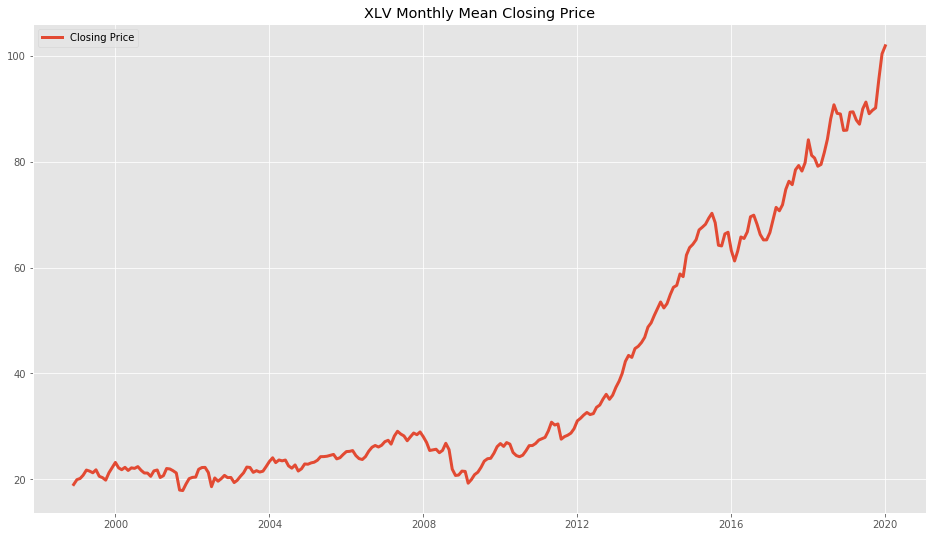

<Figure size 432x288 with 0 Axes>

In [48]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
plt.plot(xlv_monthly_mean, linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show();
plt.savefig('XLV_beginning_close_price')

#There is an upwards Trend

## Perform a Seasonal Decomposition to check for trends, seasonality, and residual distribution

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

In [50]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

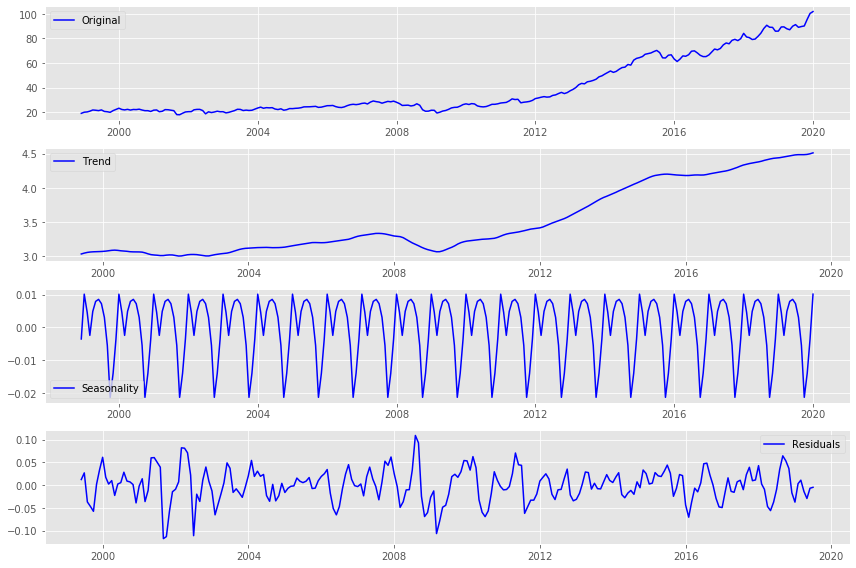

In [51]:
# Original Monthly Mean 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [52]:
#check stationarity
def stationarity_check(TS):
    
    from statsmodels.tsa.stattools import adfuller
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    dftest = adfuller(TS)
    
    fig = plt.figure(figsize = (16,9))
    orig = plt.plot(TS, color = 'b', label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey-Fuller Test')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    return None

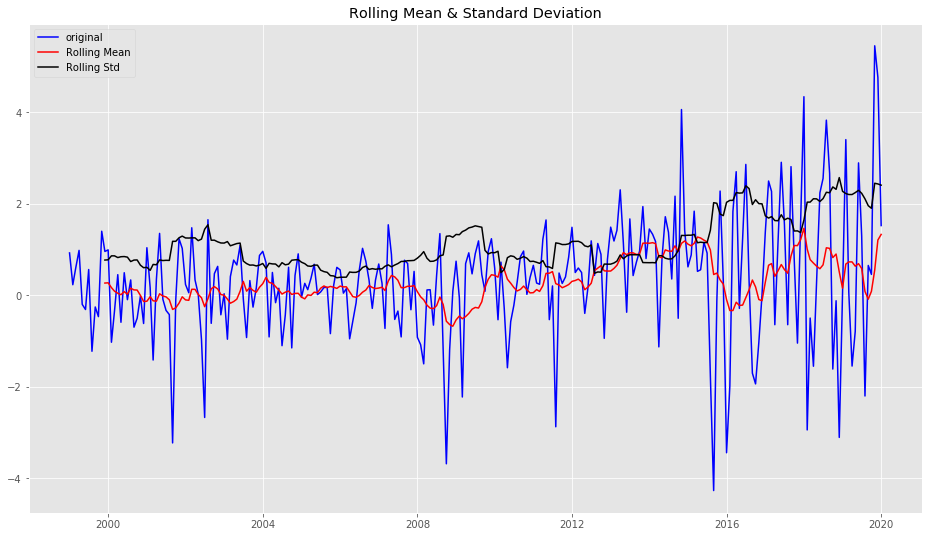

Results of Dickey-Fuller Test
Test Statistic                -1.139079e+01
p-value                        8.077680e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [53]:
#best (first order)
xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check(xlv_differenced_mean.Close)

#### P-val = 7.32e-11 -->  Reject the null hypothesis that the data is not stationary

## ARMA: Auto-Regressive - PACF

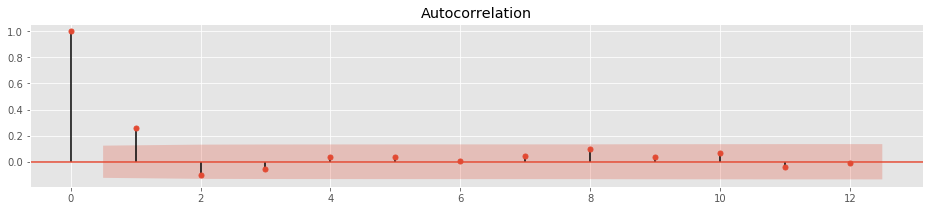

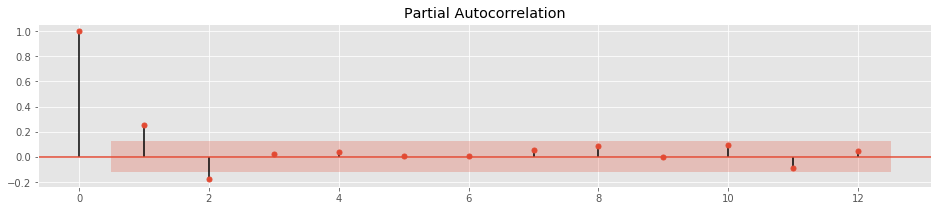

In [54]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax=ax, lags = 12);

In [55]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12));
res = mod.fit();
res.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.767
Date:                            Wed, 08 Jan 2020   AIC                            831.533
Time:                                    13:17:31   BIC                            855.927
Sample:                                12-01-1998   HQIC                           841.361
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2946      0.548      0.537      0.591      -0.780       1.369
ma.L1          0.0048      0.548      0.009      0.993      -1.069       1.078
ma.L2         -0.1950      0.190     -1.026      0.305      -0.567       0.177
ar.S.L12      -0.9997      0.070    -14.239      0.000      -1.137      -0.862
ma.S.L12       0.1522      0.762      0.200      0.842      -1.340       1.645
ma.S.L24      -0.8359      0.667     -1.254      0.210      -2.143       0.471
sigma2         1.5739      1.091      1.442      0.149      -0.565       3.713
===================================================================================
Ljung-Box (Q):                       30.18   Jarque-Bera (JB):                57.93
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.091
Date:                            Wed, 08 Jan 2020   AIC                            834.182
Time:                                    13:17:31   BIC                            851.606
Sample:                                12-01-1998   HQIC                           841.202
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2001      0.172     -1.165      0.244      -0.537       0.136
ma.L1          0.5176      0.161      3.222      0.001       0.203       0.833
ar.S.L12      -0.0766      0.074     -1.030      0.303      -0.222       0.069
ma.S.L12      -0.8334      0.061    -13.588      0.000      -0.954      -0.713
sigma2         1.6752      0.126     13.289      0.000       1.428       1.922
===================================================================================
Ljung-Box (Q):                       32.75   Jarque-Bera (JB):                50.59
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               4.37   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
xlv_monthly_auto = xlv_monthly_mean.copy()

In [58]:
xlv_monthly_mean['Close_P'] = res.predict(start = 225, end = 254, dynamic = False)

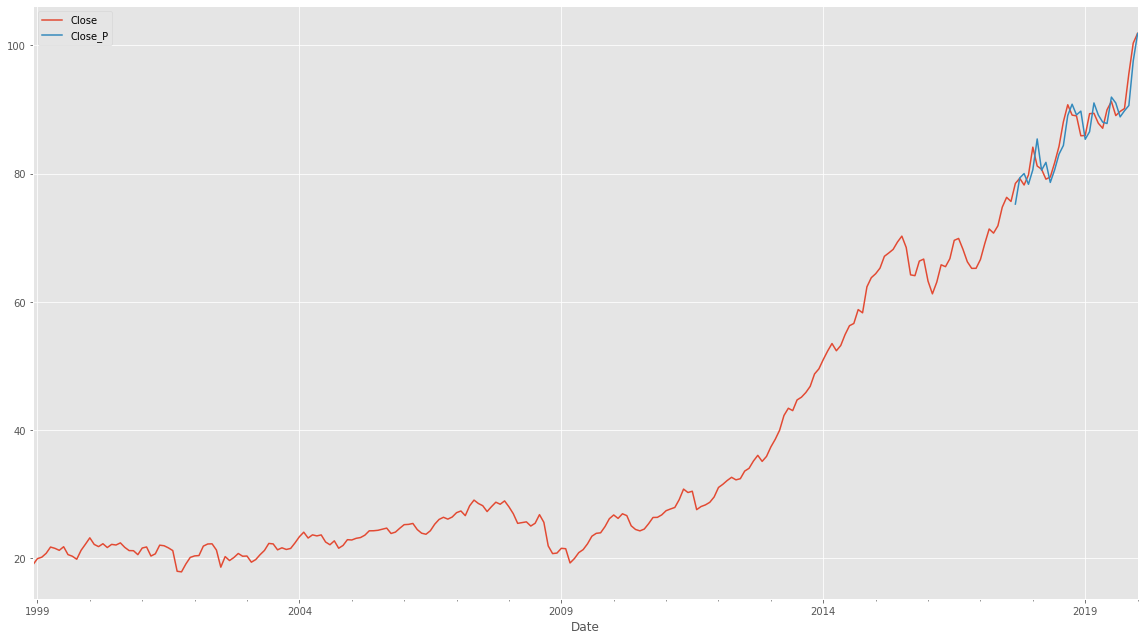

In [59]:
xlv_monthly_mean[['Close', 'Close_P']].plot(figsize = (16,9));
plt.legend(loc = 'upper left')
plt.tight_layout();

In [60]:
xlv_monthly_mean.head()

,Close,Close_P
Date,,
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN


In [61]:
from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index = date_list, columns = xlv_monthly_mean.columns)
xlv_monthly_mean = pd.concat([xlv_monthly_mean, future])

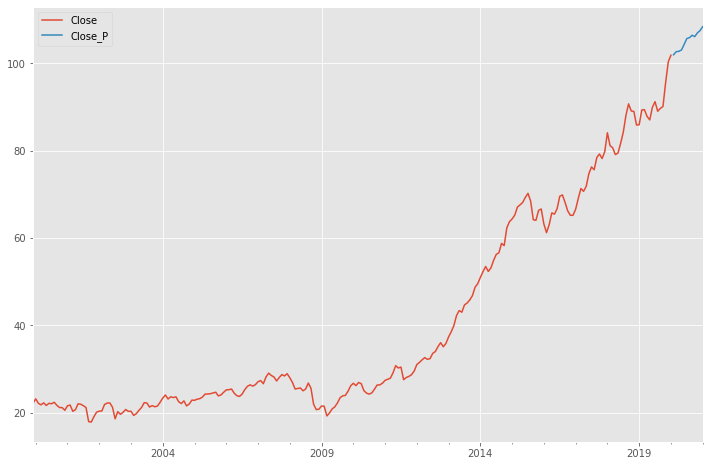

In [62]:
xlv_monthly_mean['Close_P'] = res.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_mean[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.savefig('XLV_predict_future.png', bbox_inches = 'tight')


### Dynamic Forecasting

In [63]:
prediction = res.get_forecast(steps = 36)
pred_conf = prediction.conf_int()


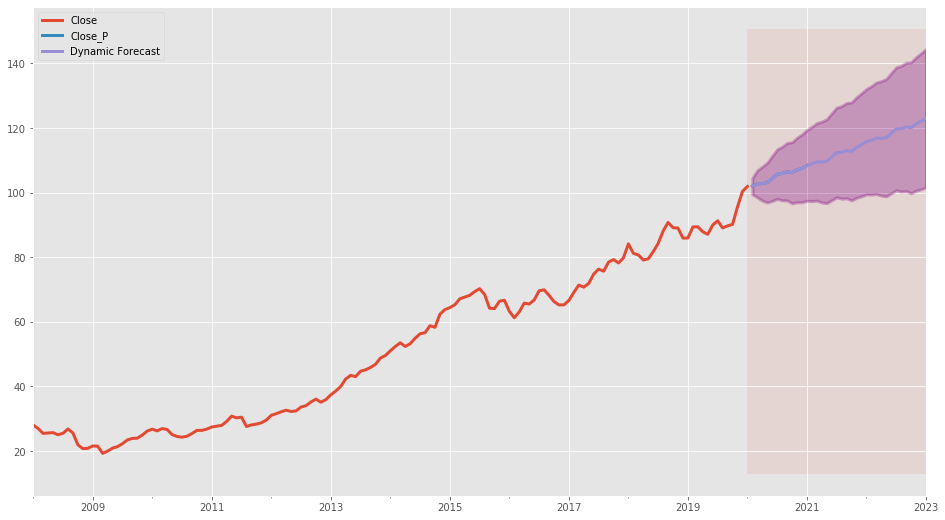

In [64]:
ax = xlv_monthly_mean['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:,0],
                pred_conf.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2023-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.show()

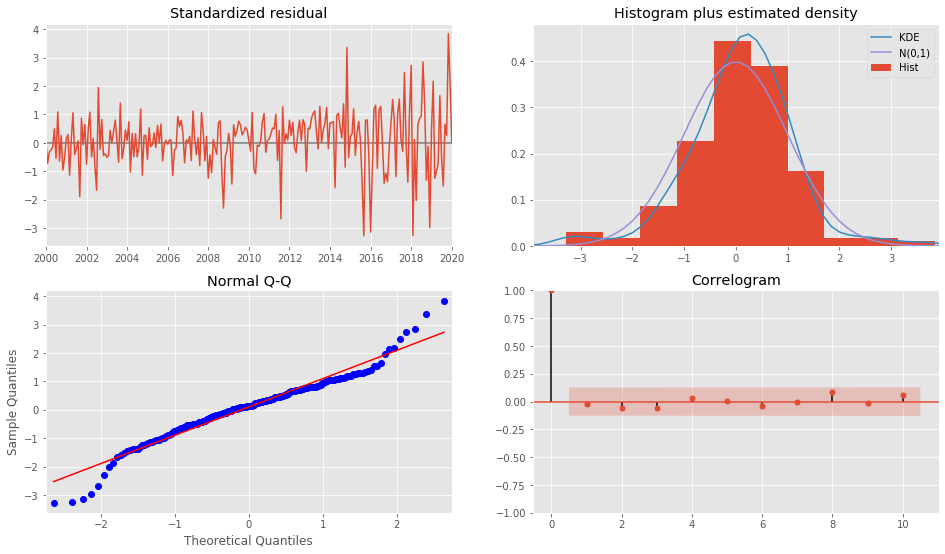

In [65]:
res.plot_diagnostics(figsize = (16,9));

## Auto-ARIMA

In [173]:
# Define the p, d and q parameters to take any value between 0 and 2
import itertools
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))
print(pdq)

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print(pdqs)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [ ]:

warnings.filterwarnings(action='once')
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean.Close, 
                                            order = comb, 
                                            seasonal_order = combs, 
                                            enforce_stationarity = False, 
                                            enforce_invertability = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {} : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC Calculated = 2654.6558191583335
ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC Calculated = 2278.2803261767426
ARIMA (0, 0, 0) x (0, 0, 2, 12) : AIC Calculated = 1979.4328828605408
ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC Calculated = 1574.0926653972679
ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC Calculated = 1458.1686421708473
ARIMA (0, 0, 0) x (0, 1, 2, 12) : AIC Calculated = 1377.5164422927637
ARIMA (0, 0, 0) x (0, 2, 0, 12) : AIC Calculated = 1476.4713184869934
ARIMA (0, 0, 0) x (0, 2, 1, 12) : AIC Calculated = 1333.0330608589234
ARIMA (0, 0, 0) x (0, 2, 2, 12) : AIC Calculated = 1270.1194153484084
ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC Calculated = 1435.1674644768414
ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC Calculated = 1430.1082774485424
ARIMA (0, 0, 0) x (1, 0, 2, 12) : AIC Calculated = 1370.874563752644
ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC Calculated = 1434.8856583935167
ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC Calculated = 1402.8801923291185
ARIMA (0, 0, 0) x (1,

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (2, 0, 2, 12) : AIC Calculated = 1357.4231255012255
ARIMA (0, 0, 0) x (2, 1, 0, 12) : AIC Calculated = 1359.4384570568116
ARIMA (0, 0, 0) x (2, 1, 1, 12) : AIC Calculated = 1341.4667453678057
ARIMA (0, 0, 0) x (2, 1, 2, 12) : AIC Calculated = 1339.4375298238804
ARIMA (0, 0, 0) x (2, 2, 0, 12) : AIC Calculated = 1285.2119606468636
ARIMA (0, 0, 0) x (2, 2, 1, 12) : AIC Calculated = 1278.123550391847
ARIMA (0, 0, 0) x (2, 2, 2, 12) : AIC Calculated = 1274.7568006115525
ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC Calculated = 2312.1402048691816


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC Calculated = 1954.1822240820477


In [25]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 2, 2)
pdqs    (1, 1, 2, 12)
aic           745.377
Name: 716, dtype: object

In [66]:
warnings.filterwarnings(action='once')
Auto_ARIMA = sm.tsa.statespace.SARIMAX(xlv_monthly_auto,
                                       order = (2,2,2),
                                       seasonal_order = (1,1,2,12),
                                       enforce_stationarity = False,
                                       enforce_invertability = False)
output_auto = Auto_ARIMA.fit()
print(output_auto.summary().tables[1])
output_auto.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1734      0.304      0.571      0.568      -0.422       0.769
ar.L2         -0.1982      0.123     -1.615      0.106      -0.439       0.042
ma.L1         -0.8796      0.333     -2.644      0.008      -1.532      -0.228
ma.L2         -0.1180      0.333     -0.355      0.723      -0.771       0.534
ar.S.L12      -0.8410      0.145     -5.792      0.000      -1.126      -0.556
ma.S.L12      -0.1140      0.172     -0.662      0.508      -0.452       0.224
ma.S.L24      -0.6899      0.166     -4.150      0.000      -1.016      -0.364
sigma2         1.6633      0.282      5.908      0.000       1.112       2.215


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -364.703
Date:                            Wed, 08 Jan 2020   AIC                            745.406
Time:                                    13:17:53   BIC                            772.297
Sample:                                12-01-1998   HQIC                           756.274
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1734      0.304      0.571      0.568      -0.422       0.769
ar.L2         -0.1982      0.123     -1.615      0.106      -0.439       0.042
ma.L1         -0.8796      0.333     -2.644      0.008      -1.532      -0.228
ma.L2         -0.1180      0.333     -0.355      0.723      -0.771       0.534
ar.S.L12      -0.8410      0.145     -5.792      0.000      -1.126      -0.556
ma.S.L12      -0.1140      0.172     -0.662      0.508      -0.452       0.224
ma.S.L24      -0.6899      0.166     -4.150      0.000      -1.016      -0.364
sigma2         1.6633      0.282      5.908      0.000       1.112       2.215
===================================================================================
Ljung-Box (Q):                       28.89   Jarque-Bera (JB):                51.40
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               5.06   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

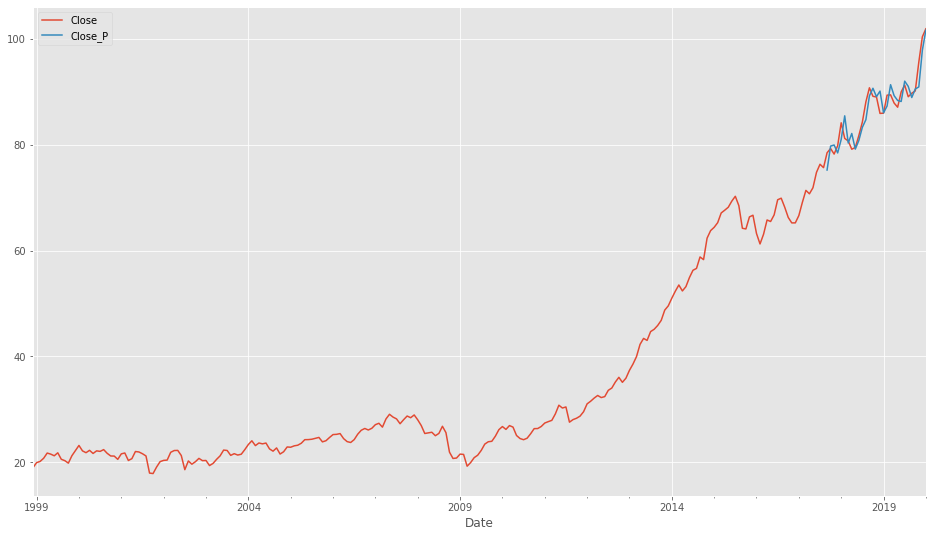

In [67]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 225, end = 254, dynamic = False)
xlv_monthly_auto[['Close', 'Close_P']].plot(figsize = (16,9))
plt.legend(loc = 'upper left')
plt.show()


In [68]:
xlv_monthly_auto

,Close,Close_P
Date,,
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN
...,...,...
2019-09-01,89.694500,88.897485
2019-10-01,90.148696,90.511486
2019-11-01,95.596500,90.899511


In [69]:
from dateutil.relativedelta import relativedelta
import datetime

start_auto = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
date_list_auto = [start_auto + relativedelta(months=x) for x in range(0,12)]
future_auto = pd.DataFrame(index = date_list_auto, columns = xlv_monthly_auto.columns)
xlv_monthly_auto = pd.concat([xlv_monthly_auto, future_auto])

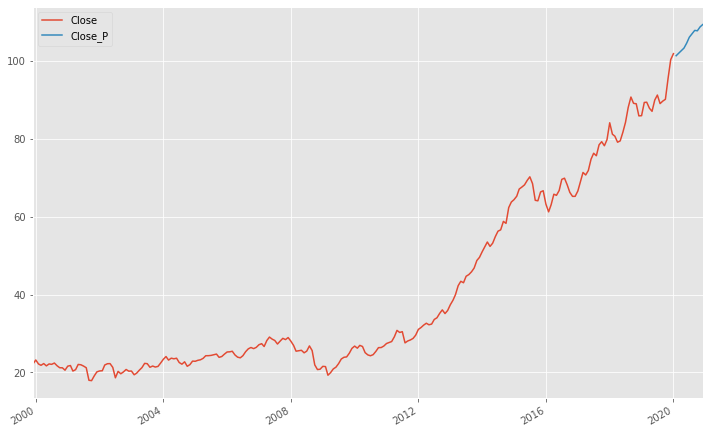

In [70]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_auto[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.legend(loc = 'upper left')
plt.show();



In [71]:
prediction_auto = output_auto.get_forecast(steps = 36)
pred_conf_auto = prediction_auto.conf_int()
pred_conf_auto

,lower Close,upper Close
2020-02-01,98.810635,103.888791
2020-03-01,97.829567,106.162063
2020-04-01,97.549931,107.769678
2020-05-01,97.500629,109.128536
2020-06-01,98.125498,111.062403
2020-07-01,99.008730,113.193200
2020-08-01,99.310525,114.661041
2020-09-01,99.636495,116.081398
2020-10-01,99.009320,116.495454
2020-11-01,99.501983,117.987358


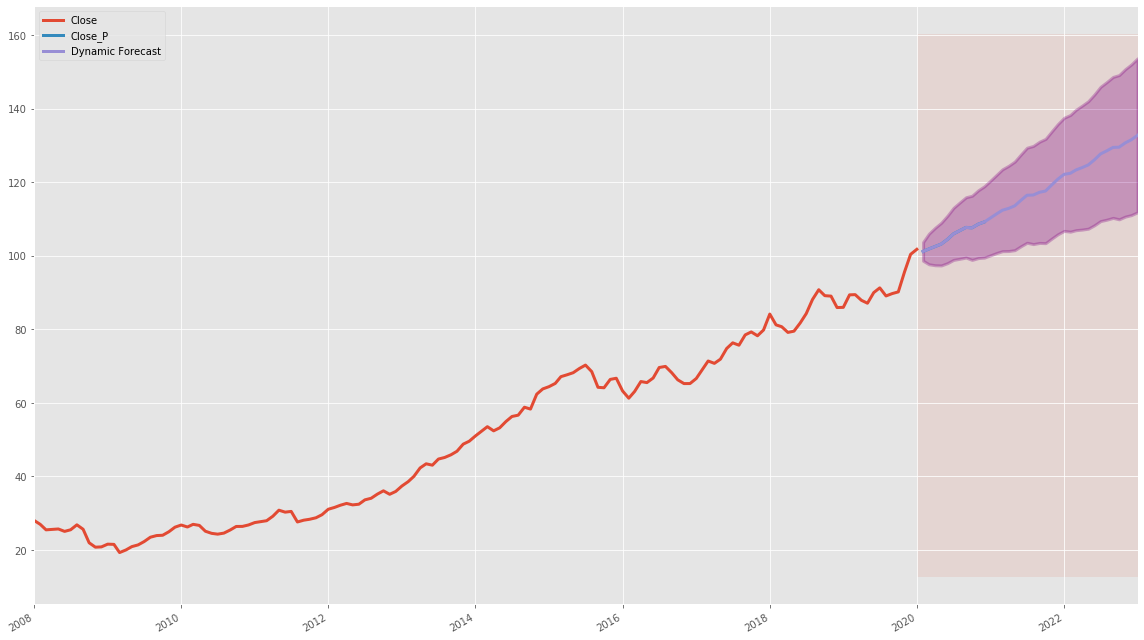

In [47]:
ax = xlv_monthly_auto['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction_auto.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf_auto.index,
                pred_conf_auto.iloc[:,0],
                pred_conf_auto.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2024-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('Auto_ARIMA_Projection.png')
plt.show();
